In [4]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn import preprocessing
import pylab
import time
import random
import matplotlib.pyplot as plt


In [61]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to show/hide code cells."></form>''')

In [ ]:
HTML('''<script>
show_image = true;
function toggle_image(){
if (show_image){

}
}
if (show_image)''')

In [62]:
HTML('''<form action="javascript:code_toggle()"><input type="submit" value="Click here to show/hide code cells."></form>''')

# Detection of input drift using PSI

* Used publically available SEA dataset
* Has three features and 2 classes (0 and 1)
* Data set consists of 60,000 rows

In [1]:
def get_decile_dist(prediction_prob_matrix):
    prob_0 = prediction_prob_matrix[:,0]
    df_prob_0 = pd.DataFrame(prob_0, columns = ['prob_0'])
    conditions = [(df_prob_0.prob_0 >= 0.9),
          ((df_prob_0.prob_0 < 0.9) & (df_prob_0.prob_0 >= 0.8)),
          ((df_prob_0.prob_0 < 0.8) & (df_prob_0.prob_0 >= 0.7)),
          ((df_prob_0.prob_0 < 0.7) & (df_prob_0.prob_0 >= 0.6)),
          ((df_prob_0.prob_0 < 0.6) & (df_prob_0.prob_0 >= 0.5)),
          ((df_prob_0.prob_0 < 0.5) & (df_prob_0.prob_0 >= 0.4)),
          ((df_prob_0.prob_0 < 0.4) & (df_prob_0.prob_0 >= 0.3)),
          ((df_prob_0.prob_0 < 0.3) & (df_prob_0.prob_0 >= 0.2)),
          ((df_prob_0.prob_0 < 0.2) & (df_prob_0.prob_0 >= 0.1)),
          (df_prob_0.prob_0 < 0.1)]

    choices = np.arange(1,11)
    df_prob_0['decile'] = np.select(conditions, choices, default = 'none')
    df_prob_0['decile'] = df_prob_0['decile'].astype(int)
    decile_dist = df_prob_0.groupby('decile')[['prob_0']].count().reset_index().sort_values(by = 'decile')
    decile_dist['decile_dist_perc'] = np.round(100*decile_dist['prob_0']/decile_dist['prob_0'].sum(),1)
    return decile_dist

    

In [2]:
def calculate_PSI(training_set, serving_set, model_recv):
    predictions_train = model_recv.predict_proba(training_set)
    training_dist = get_decile_dist(predictions_train).rename(columns = {'prob_0' : 'train_dist', 
                                                                         'decile_dist_perc' : 'train_dist_perc'})
    predictions_serving = model_recv.predict_proba(serving_set)
    serving_dist = get_decile_dist(predictions_serving).rename(columns = {'prob_0' : 'serv_dist', 
                                                                          'decile_dist_perc' : 'serv_dist_perc'})
    merged = pd.merge(training_dist, serving_dist, on='decile', how ='inner')
    
    merged['s-t'] = merged['serv_dist_perc'] - merged['train_dist_perc']

    merged['ln(s/t)'] = np.log(merged['serv_dist_perc']/merged['train_dist_perc'])

    merged['PSI'] = merged['ln(s/t)'] * (merged['s-t']/100)

    return merged.PSI.sum()
    

In [3]:
def train_model(X,y):
    seed = 369
    test_size = 0.33
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
    model_new = GaussianNB()
    model_new.fit(X_train, y_train)
    y_pred = model_new.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy after retraining: %.2f%%" % (accuracy * 100.0))
    return model_new,X_test
    
    

In [22]:
df = pd.read_csv('data/elecNormNew.csv', names = ['feature1','feature2','feature3',
                                                  'feature4','feature5','feature6',
                                                  'feature7','feature8','label'])

In [23]:
df.label.value_counts()

DOWN    26075
UP      19237
Name: label, dtype: int64

In [24]:
26075/len(df)

0.5754546257062146

In [7]:
# df.loc[15000:30000, 'feature3'] = df['feature3'] + 0.5
# df.loc[30000:45000, 'feature2'] = df['feature2'] + 1
# df.loc[20000:35000, 'feature4'] = df['feature4'] + 1
# # df.loc[45000:60000, 'feature3'] = df['feature3'] + 3

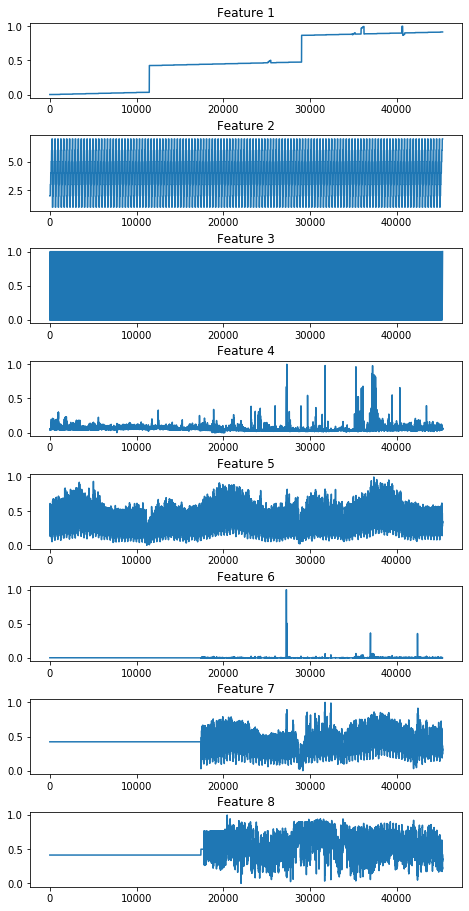

In [21]:
features = ['feature1','feature2','feature3',
            'feature4','feature5','feature6',
            'feature7','feature8']
nrow = len(features)
# fig, axes = plt.subplots(nrow)
plt.subplots_adjust(left=2, bottom=1, right=3, top=4, wspace=None, hspace=0.5)
# plot counter
count=0
for r in range(nrow):
    plt.subplot(nrow,1,count+1)
    plt.plot(df[features[count]], label = 'feature ' + str(count+1))
    plt.title('Feature '+ str(count+1))
#     plt.savefig('figs/concepts_SEA.png')  
    count+=1
    fig1 = plt.gcf()
# plt.show()
# plt.draw()
    plt.savefig('figs/concepts_SEA.png', dpi=100)
#     fig1 = plt.gcf()
    
# plt.savefig('figs/concepts_SEA.png')
# plt.show()



<img src="window.png">

# Train classifier (logistic regression) on first 15000 examples

In [8]:
df1 = df[0:15000]

In [9]:
X1 = df1[['feature1','feature2','feature3','feature4','feature5','feature6','feature7','feature8']].values
y1 = df1['label'].values
label = ["UP", "DOWN"]
le = preprocessing.LabelEncoder()
le.fit(label)
y1 = le.transform(y1)
# split data into train and test sets
seed = 9
test_size = 0.33
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=test_size, random_state=seed)
scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
# fit model no training data
model = GaussianNB()
model.fit(X1_train, y1_train)
print(model)

GaussianNB(priors=None, var_smoothing=1e-09)


In [10]:
kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=4369)
cv_results = model_selection.cross_validate(model, X1_train, y1_train, cv=kfold, scoring=scoring)
clf = model.fit(X1_train, y1_train)
cv_results

{'fit_time': array([0.00199914, 0.00200057, 0.00100064, 0.00299859, 0.00200033]),
 'score_time': array([0.00500345, 0.00499916, 0.00699854, 0.0049994 , 0.00399995]),
 'test_accuracy': array([0.80746269, 0.80597015, 0.80895522, 0.80099502, 0.80547264]),
 'test_precision_weighted': array([0.80996153, 0.80813902, 0.8104036 , 0.80252389, 0.80899218]),
 'test_recall_weighted': array([0.80746269, 0.80597015, 0.80895522, 0.80099502, 0.80547264]),
 'test_f1_weighted': array([0.80547466, 0.80328981, 0.80726745, 0.79899509, 0.80347121]),
 'test_roc_auc': array([0.88467688, 0.8813668 , 0.86863093, 0.86344602, 0.87103942])}

## Average accuracy with cross validation (5 splits) on inititial test set

In [11]:
mean_acc = 100 * cv_results['test_accuracy'].mean()
print("The mean accuracy of model is %0.2f " %mean_acc) 

The mean accuracy of model is 80.58 


In [12]:
# make predictions for test data
y1_pred = model.predict(X1_test)
# predictions = [round(value) for value in y_pred]
predictions = model.predict_proba(X1_test)

## Monitor PSI  vs accuracy - without intervention

In [14]:

# %matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

Initial model accuracy: 81.29%


C:\Users\t910571\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


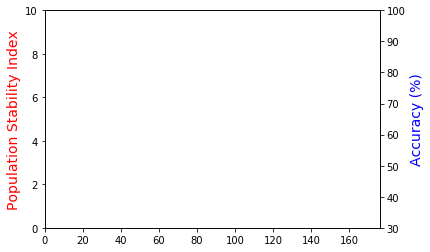

In [13]:
## Initiate model
df1 = df[0:15000]
X1 = df1[['feature1','feature2','feature3','feature4','feature5','feature6','feature7','feature8']].values
y1 = df1['label'].values
# label = ["UP", "DOWN"]
# le = preprocessing.LabelEncoder()
# le.fit(label)
# y1 = le.transform(y1)
# split data into train and test sets
seed = 9
test_size = 0.33
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=test_size, random_state=seed)
# fit model no training data
model = GaussianNB()
model.fit(X1_train, y1_train)
y1_pred = model.predict(X1_test)
accuracy = accuracy_score(y1_test, y1_pred)
print("Initial model accuracy: %.2f%%" % (accuracy * 100.0))

batch_size = 200
window_size = 10000
# fig = plt.figure(figsize=(10,20))
fig = plt.figure()
ax  = fig.add_subplot(111)
ax2=ax.twinx()
plt.ion()

fig.show()
fig.canvas.draw()

PSIs = []
acc = []
for i in range(int((len(df)-1)/batch_size)+1):
    df_temp = df[(i*batch_size):((i*batch_size)+window_size)]
    X2 = df_temp[['feature1','feature2','feature3','feature4','feature5','feature6','feature7','feature8']].values
    y2 = df_temp['label'].values

    PSIs.append(calculate_PSI(X1_test,X2,model))
    y2_pred = model.predict(X2)
    acc.append((100*accuracy_score(y2, y2_pred)))
    ax.clear()
    ax.set_xlim([0,int((len(df)-window_size)/batch_size)])
    ax2.set_xlim([0,int((len(df)-window_size)/batch_size)])
    ax.set_ylim([0,10])
    ax2.set_ylim([30,100])
    ax.plot(range(len(PSIs)),PSIs, color = 'red')
    ax.set_ylabel("Population Stability Index",color="red",fontsize=14)
    ax2.plot(range(len(acc)),acc, color = 'blue')
    ax2.set_ylabel("Accuracy (%)",color="blue",fontsize=14)

    fig.canvas.draw()
    plt.pause(0.00001)
    

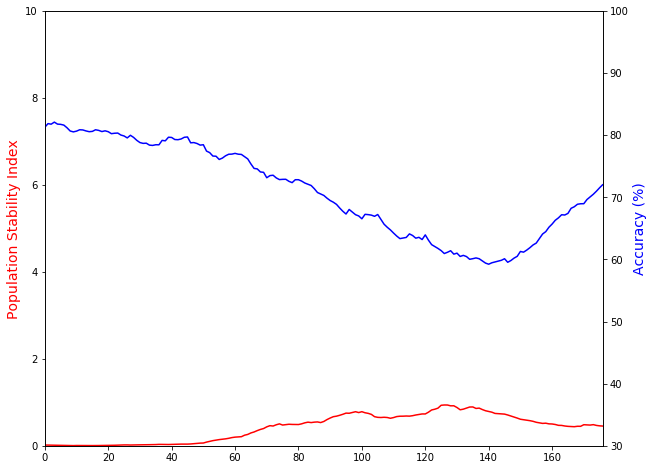

In [16]:
fig = plt.figure(figsize=(10,8))
ax  = fig.add_subplot(111)
ax2=ax.twinx()
ax.set_xlim([0,int((len(df)-window_size)/batch_size)])
ax2.set_xlim([0,int((len(df)-window_size)/batch_size)])
ax.set_ylim([0,10])
ax2.set_ylim([30,100])
ax.plot(range(len(PSIs)),PSIs, color = 'red')
ax.set_ylabel("Population Stability Index",color="red",fontsize=14)
ax2.plot(range(len(acc)),acc, color = 'blue')
ax2.set_ylabel("Accuracy (%)",color="blue",fontsize=14)
plt.savefig('figs/PSI_wo_intervention_NSW.png')

In [17]:
np.mean(acc)

72.2095605800208

## Monitor accuracy with intervention at PSI >0.05

Initial model accuracy: 81.61%


C:\Users\t910571\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


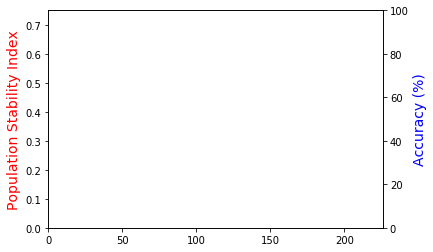

Accuracy after retraining: 81.67%
Accuracy after retraining: 76.03%
Accuracy after retraining: 71.00%
Accuracy after retraining: 70.94%
Accuracy after retraining: 83.78%


In [18]:
batch_size = 200
window_size = 10000
## Initiate model
df1 = df[0:window_size]
X1 = df1[['feature1','feature2','feature3','feature4','feature5','feature6','feature7','feature8']].values
y1 = df1['label'].values
# split data into train and test sets
seed = 9
test_size = 0.33
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=test_size, random_state=seed)
# fit model no training data
model = GaussianNB()
model.fit(X1_train, y1_train)
y1_pred = model.predict(X1_test)
accuracy = accuracy_score(y1_test, y1_pred)
print("Initial model accuracy: %.2f%%" % (accuracy * 100.0))




# fig = plt.figure(figsize=(10,20))
fig = plt.figure()
ax  = fig.add_subplot(111)
ax2=ax.twinx()
plt.ion()

fig.show()
fig.canvas.draw()

PSIs = []
acc = []
for i in range(int((len(df)-1)/batch_size)+1):

    df_temp = df[(i*batch_size):((i*batch_size)+window_size)]
    X2 = df_temp[['feature1','feature2','feature3','feature4','feature5','feature6','feature7','feature8']].values
    y2 = df_temp['label'].values
#     PSIs.append(calculate_PSI(X1_test,df[i*batch_size,(i*batch_size)+window_size],model))
    PSI_new = calculate_PSI(X1_test,X2,model)
    PSIs.append(PSI_new)
    y2_pred = model.predict(X2)
#     print((100*accuracy_score(y2, y2_pred)))
    acc.append((100*accuracy_score(y2, y2_pred)))
    ax.clear()
    ax.set_xlim([0,int((len(df))/batch_size)])
    ax2.set_xlim([0,int((len(df))/batch_size)])
    ax.set_ylim([0,0.75])
    ax2.set_ylim([0,100])
    ax.plot(range(len(PSIs)),PSIs, color = 'red')
    ax.set_ylabel("Population Stability Index",color="red",fontsize=14)
    ax2.plot(range(len(acc)),acc, color = 'blue')
    ax2.set_ylabel("Accuracy (%)",color="blue",fontsize=14)

    fig.canvas.draw()
    plt.pause(0.001)
    
    if PSI_new>0.25:
        model,new_ref_df = train_model(X2,y2)
#         print("new PSI = ", calculate_PSI(X2,X2,model))
        X1_test = X2
        

        

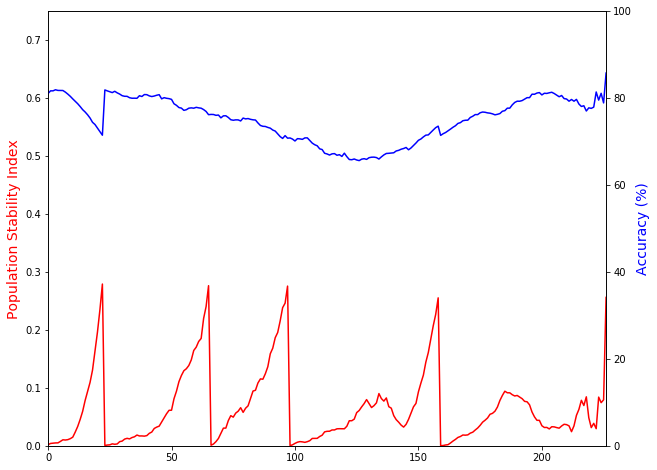

In [22]:
fig = plt.figure(figsize=(10,8))
ax  = fig.add_subplot(111)
ax2=ax.twinx()
ax.set_xlim([0,int((len(df))/batch_size)])
ax2.set_xlim([0,int((len(df))/batch_size)])
ax.set_ylim([0,0.75])
ax2.set_ylim([0,100])
ax.plot(range(len(PSIs)),PSIs, color = 'red')
ax.set_ylabel("Population Stability Index",color="red",fontsize=14)
ax2.plot(range(len(acc)),acc, color = 'blue')
ax2.set_ylabel("Accuracy (%)",color="blue",fontsize=14)
plt.savefig('figs/PSI_w_intervention_NSW.png')

In [21]:
np.mean(acc)

75.15442682293819